In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam


In [86]:
train= pd.read_csv('../kaggleDatasets/NLP_Disaster_Tweets/train.csv')
test=pd.read_csv('../kaggleDatasets/NLP_Disaster_Tweets/test.csv')
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [87]:
print(train.shape)
print(test.shape)

(7613, 5)
(3263, 4)


## Visualization

/home/ubuntu/anaconda3/envs/universal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='target'>

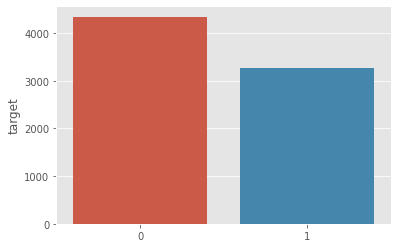

In [88]:
x = train.target.value_counts()
sns.barplot(x.index,x)
# plt.gca().set_ylabel('samples')

Text(0.5, 1.0, 'Not Disaster Tweets')

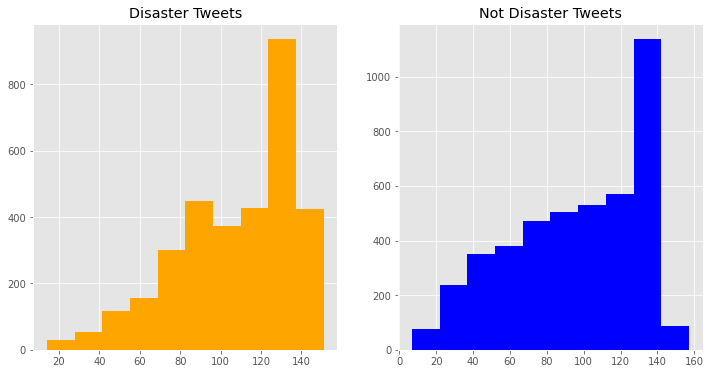

In [89]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (12,6))
train_len = train[train['target']== 1]['text'].str.len()
ax1.hist(train_len,color='orange')
ax1.set_title('Disaster Tweets')
train_len = train[train['target']== 0]['text'].str.len()
ax2.hist(train_len,color='blue')
ax2.set_title('Not Disaster Tweets')

Text(0.5, 1.0, 'Not Disaster Tweets')

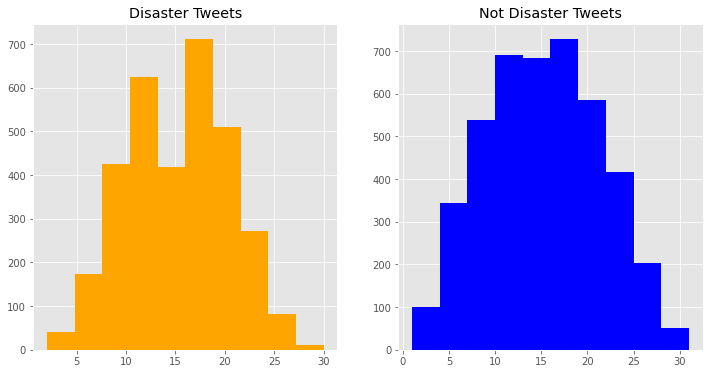

In [90]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (12,6))
train_len = train[train['target']== 1]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_len,color='orange')
ax1.set_title('Disaster Tweets')
train_len = train[train['target']== 0]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_len,color='blue')
ax2.set_title('Not Disaster Tweets')

In [91]:
def create_corpus(target):
    corpus = []
    for x in train[train['target']== target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

#### STOP WORDS

In [92]:
corpus=create_corpus(0)
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
top = sorted(dic.items(),key=lambda x:x[1],reverse = True)[:10]

<BarContainer object of 10 artists>

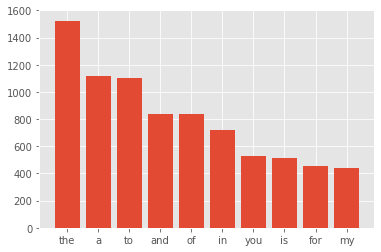

In [93]:
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

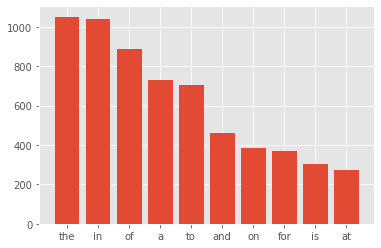

In [94]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

#### COMMON WORDS

<AxesSubplot:>

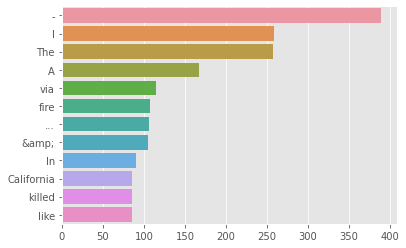

In [95]:
counter = Counter(corpus)
most = counter.most_common()
x , y =  [], []
for word, count in most[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

#### N-gram analysis

In [96]:
def get_top_tweet_bigrams(corpus,n = None):
    vec = CountVectorizer(ngram_range = (2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x:x[1], reverse = True)
    return words_freq[:n]


<AxesSubplot:>

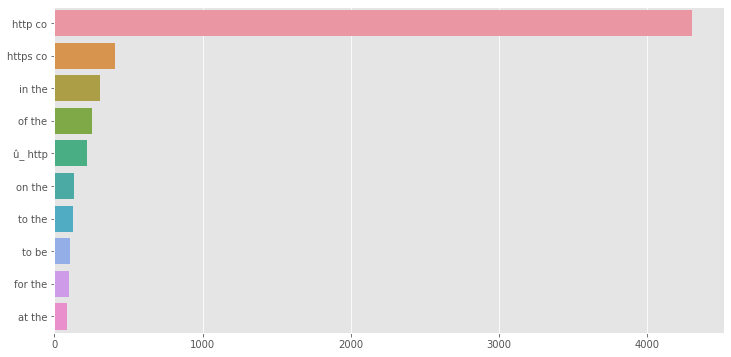

In [97]:
plt.figure(figsize = (12,6))
top_tweet_bigrams = get_top_tweet_bigrams(train['text'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

## Data Cleaning

In [98]:
df = pd.concat([train,test])
df.shape

(10876, 5)

In [99]:
def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


In [100]:
df['text'] = df['text'].apply(lambda x: remove_urls(x))

In [101]:
def remove_html_tags(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

In [102]:
df['text']=df['text'].apply(lambda x : remove_html_tags(x))

In [103]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [104]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [105]:
def remove_punctuations(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
    

In [106]:
df['text']=df['text'].apply(lambda x : remove_punctuations(x))

In [107]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0
2,5,NaN,NaN,All residents asked to shelter in place are be...,1.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1.0


In [108]:
spell = SpellChecker()
def correct_spellings(text):
    correct_text =[]
    misspelled_words = spell.unknownwn(text.split())
    for word in text.split():
        if word in misspelled_words:
            correct_text.append(spell.correction(word))
        else:
            correct_text.append(word)
    return ' '.join(correct_text)

### GLoVe for Vectorization

In [123]:
def create_corpus(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(tweet) if ((word.isalpha() == 1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [124]:
corpus = create_corpus(df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10876/10876 [00:00<00:00, 18511.32it/s]


In [126]:
embedding_dict = {}
with open('../model/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
    f.close()

In [127]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

tweet_pad = pad_sequences(sequences, maxlen = MAX_LEN, truncating='post', padding = 'post')

In [129]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))


Number of unique words: 20342


In [131]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20342/20342 [00:00<00:00, 602699.36it/s]


## Baseline Model

In [133]:
model = Sequential()
embedding = Embedding(num_words,100, embeddings_initializer=Constant(embedding_matrix), input_length = MAX_LEN, trainable = False)
model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64,dropout=0.2, recurrent_dropout = 0.2))
model.add(Dense(1, activation = 'sigmoid'))

optimizer = Adam(learning_rate = 1e-5)
model.compile(loss ='binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [134]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2034300   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [135]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [136]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [137]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
1618/1618 - 73s - loss: 0.6910 - accuracy: 0.5707 - val_loss: 0.6865 - val_accuracy: 0.5657 - 73s/epoch - 45ms/step
Epoch 2/15
1618/1618 - 72s - loss: 0.5888 - accuracy: 0.6959 - val_loss: 0.5177 - val_accuracy: 0.7785 - 72s/epoch - 44ms/step
Epoch 3/15
1618/1618 - 70s - loss: 0.5316 - accuracy: 0.7540 - val_loss: 0.4995 - val_accuracy: 0.7872 - 70s/epoch - 43ms/step
Epoch 4/15
1618/1618 - 69s - loss: 0.5209 - accuracy: 0.7628 - val_loss: 0.4903 - val_accuracy: 0.7916 - 69s/epoch - 43ms/step
Epoch 5/15
1618/1618 - 69s - loss: 0.5087 - accuracy: 0.7707 - val_loss: 0.4828 - val_accuracy: 0.7916 - 69s/epoch - 42ms/step
Epoch 6/15
1618/1618 - 68s - loss: 0.5031 - accuracy: 0.7711 - val_loss: 0.4782 - val_accuracy: 0.7907 - 68s/epoch - 42ms/step
Epoch 7/15
1618/1618 - 58s - loss: 0.4946 - accuracy: 0.7790 - val_loss: 0.4738 - val_accuracy: 0.7933 - 58s/epoch - 36ms/step
Epoch 8/15
1618/1618 - 60s - loss: 0.4909 - accuracy: 0.7787 - val_loss: 0.4691 - val_accuracy: 0.7942 - 60s/ep

In [138]:
sample_sub=pd.read_csv('../kaggleDatasets/NLP_Disaster_Tweets/sample_submission.csv')


In [139]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

102/102 [==============================] - 2s 14ms/step
